## Setup notebook

In [0]:
# Install library and versions below
%pip install spacy==3.7.5 spacy-transformers==1.3.5 mlflow dill > /dev/null 2>&1
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# Core utilities
import json, re, logging, warnings, base64, pickle, dill

# Data handling and NLP
import pandas as pd, spacy

# MLflow components
import mlflow, mlflow.spacy, mlflow.pyfunc

In [0]:
# Various logging ignoring
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)
logging.getLogger("mlflow").setLevel(logging.ERROR)

warnings.filterwarnings(
    "ignore",
    message=".*torch.cuda.amp.autocast.*",
    category=FutureWarning
)

warnings.filterwarnings(
    "ignore",
    message=".*Add type hints to the `predict` method.*",
    category=UserWarning
)

warnings.filterwarnings(
    "ignore",
    message=".*empty Series will be 'object' instead of 'float64'.*",
    category=FutureWarning
)

warnings.filterwarnings(
    "ignore", 
    message="Token indices sequence length is longer than the specified maximum sequence length"
)

warnings.filterwarnings(
    "ignore",
    message=".*torch.utils._pytree*",
    category=FutureWarning
)

pd.set_option('display.max_colwidth', 50)

### Load job descriptions to be analysed
1. These job decsriptions will first have their content parsed by a NER model, extracting mentions of benefits
2. A cleaning function prepares the output for the Text Classification model
3. Apply the Benefits Text Classification model to categorise extracted benefits into one of predefined list of benefit categories

In [0]:
df_data = pd.read_csv('/Workspace/Users/justin.ngam@towerswatson.com/1_Benefits/0_Production/temp/git_test.csv')
df_data.head(5)

,id,title,industry,country,text
0,145095,Assistant Underwriter,Insurance,United Kingdom,Pen Underwriting have an amazing chance to wor...
1,145123,Junior Account Handler ( UK Motor Trade Division),Insurance,United Kingdom,Performs standard tasks using established and ...
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y..."
3,156197,"Analyst, Portfolio Management",Financial Services,United Kingdom,Notes to applicants:Most roles at Dimensional ...
4,158803,Digital Markets Correspondent,Media,United Kingdom,The Role\nThe Financial Times is hiring a digi...


## Run job descriptions through NER model to extract benefits
I've stored the pretrained model into MLFlow within Databricks, for better model housekeeping. All I have to do is call the correct 'run_id' to load the model

In [0]:
# INSTRUCTION: Edit 'run_id' to match MLFlow of NER model
run_id = "54cac5d165bd4dce8689767153640deb"

model_uri = f"runs:/{run_id}/best"
nlp_ner = mlflow.spacy.load_model(model_uri)

In [0]:
# Apply NER model to extract benefits 
def extract_benefits(text):
    doc = nlp_ner(text)
    return " ||| ".join([ent.text for ent in doc.ents])

df_data['model_extracted_benefits'] = df_data['text'].apply(extract_benefits)
df_data.head(10)

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


,id,title,industry,country,text,model_extracted_benefits
0,145095,Assistant Underwriter,Insurance,United Kingdom,Pen Underwriting have an amazing chance to wor...,
1,145123,Junior Account Handler ( UK Motor Trade Division),Insurance,United Kingdom,Performs standard tasks using established and ...,
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y...",Fully funded Qualifications ||| Learning and D...
3,156197,"Analyst, Portfolio Management",Financial Services,United Kingdom,Notes to applicants:Most roles at Dimensional ...,hybrid working model
4,158803,Digital Markets Correspondent,Media,United Kingdom,The Role\nThe Financial Times is hiring a digi...,generous annual leave allowances ||| flexible ...
5,160235,Advanced Building Design Consultant,Professional Services,United Kingdom,"About Us\nAt HDR, we specialize in engineering...",
6,161234,Electrical Graduate Engineer,Professional Services,United Kingdom,"About Us\nAt HDR, we specialize in engineering...",
7,171006,Finance Analyst,Manufacturing,United Kingdom,CREATIVITY IS OUR SUPERPOWER. It’s our heritag...,personal pension scheme ||| private healthcare...
8,177496,Manager Technology_Java- Core,Professional Services,United Kingdom,Publicis Sapient is a digital transformation p...,Comprehensive private healthcare covering pre-...
9,178576,Global Programmatic Account Director,Professional Services,United Kingdom,We think big. And act bigger. Stay versatile a...,


### Clean-up function to prepare extracted benefits for Text Categorisation model
1. This includes exploding rows so that job descriptions with more than 1 benefit have a benefit per row
2. Cleans exploded benefits for grammer/extract characters/etc.

In [0]:
def split_benefits(df, model_extracted_benefits, benefits_split):
    new_rows = []

    # Iterate through the DataFrame
    for idx, row in df.iterrows():
        benefits = str(row[model_extracted_benefits]).split(' ||| ')
        for benefit in benefits:
            new_row = row.copy()
            new_row[benefits_split] = benefit
            new_rows.append(new_row)
    return pd.DataFrame(new_rows)

In [0]:
df_split_benefits = split_benefits(df_data, 'model_extracted_benefits', 'benefits_split')
df_split_benefits.head(10)

,id,title,industry,country,text,model_extracted_benefits,benefits_split
0,145095,Assistant Underwriter,Insurance,United Kingdom,Pen Underwriting have an amazing chance to wor...,,
1,145123,Junior Account Handler ( UK Motor Trade Division),Insurance,United Kingdom,Performs standard tasks using established and ...,,
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y...",Fully funded Qualifications ||| Learning and D...,Fully funded Qualifications
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y...",Fully funded Qualifications ||| Learning and D...,Learning and Development Courses
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y...",Fully funded Qualifications ||| Learning and D...,"25 Days Annual Leave, Plus Bank Holidays"
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y...",Fully funded Qualifications ||| Learning and D...,Pension Package
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y...",Fully funded Qualifications ||| Learning and D...,Subsidised Gym Membership
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y...",Fully funded Qualifications ||| Learning and D...,Life Assurance
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y...",Fully funded Qualifications ||| Learning and D...,Group Income Protection
2,145210,DBA,Insurance,United Kingdom,"DBA\nBased in our Ipswich waterfront office, y...",Fully funded Qualifications ||| Learning and D...,Season Ticket Loans


In [0]:
def clean_dataframe(df, text_column):
    # Reset the index to ensure it is properly aligned
    df = df.reset_index(drop=True)

    # Initialize counter to track total number of replacements
    counter_fixes = 0

    # Create a new column for the cleaned text
    df['benefits_cleaned'] = df[text_column]

    # Define the cleaning function
    def clean_text(text):
        nonlocal counter_fixes
        
        # Check if the input is a string; if not, return as is
        if not isinstance(text, str):
            return text
        
        original_text = text  # Keep the original text for comparison

        # Use regex to remove unwanted characters and words at the end
        cleaned_text = re.sub(
            r'([.,;:!•\-?(]*\b(and|or)\b[.,;:!•\-?(]*|[.,;:!•\-?(]+)$',
            '',
            text
        ).strip()

        # Additional check for text ending with ')' but no '(' elsewhere
        if cleaned_text.endswith(')') and '(' not in cleaned_text[:-1]:
            cleaned_text = cleaned_text[:-1].rstrip()

        # Update counter if changes were made
        if cleaned_text != original_text:
            counter_fixes += 1

        return cleaned_text

    # Apply the cleaning function to the text column
    df['benefits_cleaned'] = df[text_column].apply(clean_text)

    # Print the total number of changes made
    print(f"Total replacements made: {counter_fixes}")

    return df

In [0]:
df_cleaned = clean_dataframe(df_split_benefits, 'benefits_split')
df_cleaned = df_cleaned.drop(columns=['text', 'benefits_split'])

Total replacements made: 420


## Run extracted benefits through Text Classification model to categorise
Again, all I have to do is call the correct 'run_id' to load the model!

In [0]:
# INSTRUCTION: Edit 'run_id' to match MLFlow of Classification model
textclass_run_id = "5a2e790b17d945a6af3b81d1cc85540d"

textclass_model_uri = f"runs:/{textclass_run_id}/best"
nlp_textclass = mlflow.spacy.load_model(textclass_model_uri)

In [0]:
def extract_labels_info(text):
    """
    Applies the nlp_textclass model to 'text' and returns one column per category in doc.cats, each storing its confidence score (optionally thresholded).
    """
    # Check if 'text' is a non-empty string
    if not isinstance(text, str) or not text.strip():
        return pd.Series({})
    try:
        # Apply the NLP categorization model
        doc = nlp_textclass(text)
    except Exception:
        return pd.Series({})
    category_scores = {}
    for cat_name, cat_score in doc.cats.items():
        category_scores[cat_name] = round(cat_score, 3)
    return pd.Series(category_scores)

In [0]:
# Classifiy benefits using Model
df_results = df_cleaned['benefits_cleaned'].apply(
    lambda x: extract_labels_info(x)
)
df_benefits_classified = df_cleaned.join(df_results)

## Set a single overall confidence threshold to apply to all benefits
For every benefit, the Benefits Text Classification model generates a confidence level (0 to 1) per predefined benefit category. The choice of the confidence threshold decides how confident the model should be when categorising a benefit (the higher, the more confident it needs to be!)

In [0]:
# 0.9 is the industry standard for 'very accurate' and suggested to be set at this level

overall_threshold = 0.9

In [0]:
def extract_labels_info_single_threshold(text, overall_threshold):
    """
    Applies the nlp_categorisation model to 'text' and returns:
      - 'labels': a list of categories where confidence >= threshold
      - 'scores': the corresponding confidence scores of the above
    All categories are measured against the same threshold.
    """
    # 1. Quick checks for valid text
    if not isinstance(text, str) or not text.strip():
        return pd.Series({'labels': [], 'scores': []})
    
    # 2. Attempt to apply the model
    try:
        doc = nlp_textclass(text)
    except Exception:
        return pd.Series({'labels': [], 'scores': []})
    
    # 3. If doc.cats is empty or missing
    if not hasattr(doc, 'cats') or not doc.cats:
        return pd.Series({'labels': [], 'scores': []})
    
    # 4. Sort categories by descending confidence
    sorted_cats = sorted(doc.cats.items(), key=lambda item: item[1], reverse=True)
    
    # 5. Filter categories using the single threshold
    labels_and_scores = [(lbl, sc) for (lbl, sc) in sorted_cats if sc >= overall_threshold]
    
    # 6. Build lists for labels and scores
    labels = [lbl for (lbl, sc) in labels_and_scores]
    scores = [round(sc, 3) for (lbl, sc) in labels_and_scores]
    
    return pd.Series({
        'labels': labels,
        'scores': scores
    })

In [0]:
# Applying confidence threshold
df_results = df_benefits_classified['benefits_cleaned'].apply(lambda x: extract_labels_info_single_threshold(x, overall_threshold))
df_benefits_classified_threshold = df_benefits_classified.join(df_results)

In [0]:
columns_to_drop = ['model_extracted_benefits', 'Learning_&_Development_Benefits', 'Emotional_Wellbeing', 'Variable_Pay_Programs', 'Healthcare_Benefits', 'Financial_Wellbeing', 'Commuting_Benefits', 'DE&I_Benefits', 'Relocation_&_Housing_Programs', 'Referral_Programs', 'Maternity_Paternity_and_Parental_Leave', 'Perks', 'Special_Leave', 'Paid_Time_Off', 'Meal_Benefits', 'Other', 'Physical_Wellbeing', 'Flexible_Working_Benefits', 'Social_Wellbeing', 'Remote_Working_Benefits', 'Retirement', 'Company_Car_Benefits', 'Risk_Benefits', 'Vacation_Purchase_Programs', 'Adoption_and_Fertility']

df_benefits_classified_threshold = df_benefits_classified_threshold.drop(columns=columns_to_drop)
df_benefits_classified_threshold.head(10)

,id,title,industry,country,benefits_cleaned,labels,scores
0,145095,Assistant Underwriter,Insurance,United Kingdom,,[],[]
1,145123,Junior Account Handler ( UK Motor Trade Division),Insurance,United Kingdom,,[],[]
2,145210,DBA,Insurance,United Kingdom,Fully funded Qualifications,[],[]
3,145210,DBA,Insurance,United Kingdom,Learning and Development Courses,[Learning_&_Development_Benefits],[1.0]
4,145210,DBA,Insurance,United Kingdom,"25 Days Annual Leave, Plus Bank Holidays",[Paid_Time_Off],[1.0]
5,145210,DBA,Insurance,United Kingdom,Pension Package,[Retirement],[1.0]
6,145210,DBA,Insurance,United Kingdom,Subsidised Gym Membership,[Physical_Wellbeing],[1.0]
7,145210,DBA,Insurance,United Kingdom,Life Assurance,[Risk_Benefits],[0.998]
8,145210,DBA,Insurance,United Kingdom,Group Income Protection,[Risk_Benefits],[0.997]
9,145210,DBA,Insurance,United Kingdom,Season Ticket Loans,[Commuting_Benefits],[1.0]


## Visualising some high-level insights

The dataset we've analysed is for a sample of UK job descriptions, scraped from various job posting websites, for Q4 2024

We will visualise:
1. Most popular benefits
2. Benefit popularity differences between industries

In [0]:
import matplotlib.pyplot as plt

# 1. Explode the 'labels' column to get correct count numbes
df_exploded = df_benefits_classified_threshold.explode('labels')

# 2. Count occurances for each benefit category
benefit_categories = ['Learning_&_Development_Benefits', 'Emotional_Wellbeing', 'Variable_Pay_Programs', 'Healthcare_Benefits', 'Financial_Wellbeing', 'Commuting_Benefits', 'DE&I_Benefits', 'Relocation_&_Housing_Programs', 'Referral_Programs', 'Maternity_Paternity_and_Parental_Leave', 'Special_Leave', 'Meal_Benefits', 'Other', 'Physical_Wellbeing', 'Flexible_Working_Benefits', 'Social_Wellbeing', 'Remote_Working_Benefits', 'Company_Car_Benefits', 'Risk_Benefits', 'Vacation_Purchase_Programs', 'Adoption_and_Fertility']

benefit_counts = df_exploded['labels'].value_counts().reindex(benefit_categories, fill_value=0)
sorted_benefit_counts = benefit_counts.sort_values(ascending=True)

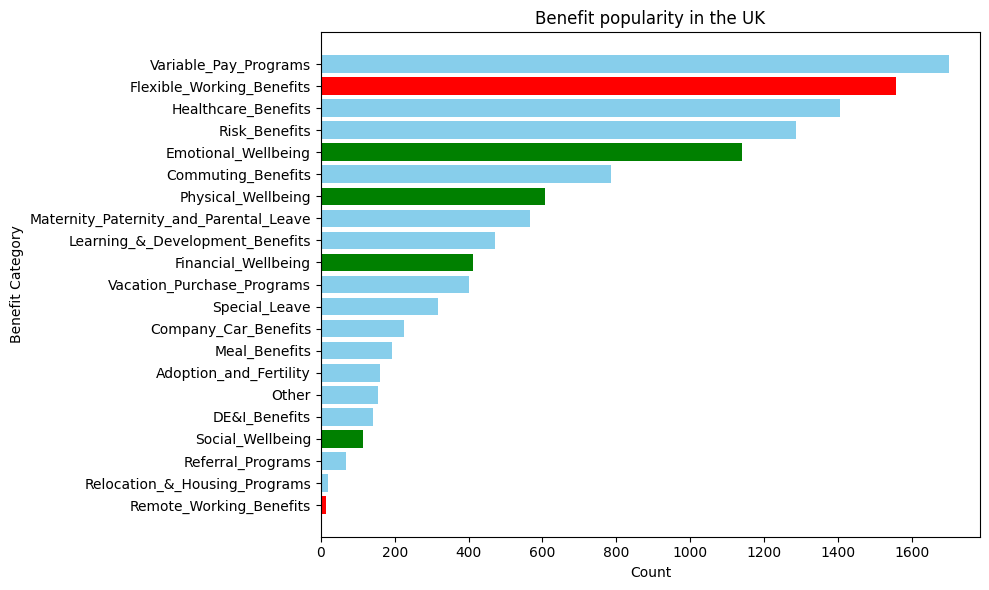

In [0]:
# 3. Plot bar chart
color_map = {
    'Flexible_Working_Benefits': 'red',
    'Remote_Working_Benefits': 'red',
    'Emotional_Wellbeing': 'green',
    'Physical_Wellbeing': 'green',
    'Social_Wellbeing':'green',
    'Financial_Wellbeing':'green'
}

bar_colors = [color_map.get(label, 'skyblue') for label in sorted_benefit_counts.index]

plt.figure(figsize=(10,6))
plt.barh(sorted_benefit_counts.index, sorted_benefit_counts.values, color=bar_colors)
plt.xlabel('Count')
plt.ylabel('Benefit Category')
plt.title('Benefit popularity in the UK')
plt.tight_layout()
plt.show()

## Insights:
1. **Flexible / Hybrid Working is here to stay in the UK:** 'Flexible_Working_Benefits' relates to benefits allowing employees flexibility to work from home. It is extremely popular, compared to 'Remote_Working_Benefits' which is the least popular benefit 
2. **Employers are prioritising employee mental health:** 'Emotional_Wellbeing' relates to benefits supporting employee's mental health e.g. EPA, counselling, therapy. This is significantly more popular than the other 3 types of wellbeing benefits: Physical_Wellbeing, Financial_Wellbeing, Social_Wellbeing

## Future Insights:
True insight comes about when we're comparing our data! See below some ideas
1. **How does benefits differ per industry:** Different industries priotise benefits differently, and HR professionals hiring will need to note that e.g. flexible working benefits would be a priority for industries like Technology & Financial Services vs Retail
2. **How has benefits changed over time:** This tells us about benefit trends, helping HR professionals future-proof employee retention by getting ahead of the trend e.g. benefits supporting employee mental health has been rising in the 2020s vs the previous decade

## 